## Load and Preprocess

#### Importing Libraries


In [2]:
#Installing the needed libraries
!pip install librosa tensorflow matplotlib


In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
screaming_file_path = '/content/drive/My Drive/DeepLearning/code/dataset/Screaming'
notScreaming_file_path = '/content/drive/My Drive/DeepLearning/code/dataset/NotScreaming'
train_file_path = '/content/drive/My Drive/DeepLearning/code/dataset/Train_audios'

Applying zero-padding in order to have the same durations to all data.

In [7]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def pad_audio(audio, sr, max_length):
    max_len_samples = int(max_length * sr)
    if len(audio) < max_len_samples:
        # Pad the audio with zeros (silence)
        padding = max_len_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    else:
        # Truncate the audio
        audio = audio[:max_len_samples]
    return audio

def extract_features(file_path):
    max_length = 10.0
    y, sr = librosa.load(file_path, sr=None)
    y = pad_audio(y, sr, max_length)
    features = []

    # Extract features
    duration = librosa.get_duration(y=y, sr=sr)
    amplitude = np.max(np.abs(y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12), axis=1)
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40), axis=1)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    spectral_flux = np.mean(librosa.onset.onset_strength(y=y, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    rms = np.mean(librosa.feature.rms(y=y))
    energy = np.sum(y**2)

    # Append all features to the list
    features.extend([duration, amplitude, zcr, spectral_centroid, spectral_bandwidth, spectral_rolloff, spectral_flux, spectral_flatness, rms, energy])
    features.extend(mfcc)
    features.extend(chroma)
    features.extend(mel_spectrogram)
    features.append(spectral_contrast)  # Append the float value as an element in the list

    return np.array(features)

def load_and_preprocess_data(scream_folder, non_scream_folder):
    features = []
    labels = []
    file_paths = []

    # Load scream data
    for filename in os.listdir(scream_folder):
        if filename.endswith('.wav'):
            path = os.path.join(scream_folder, filename)
            feature = extract_features(path)
            features.append(feature)
            labels.append(1)  # Use integer labels, e.g., 1 for scream
            file_paths.append(path)

    # Load non-scream data
    for filename in os.listdir(non_scream_folder):
        if filename.endswith('.wav'):
            path = os.path.join(non_scream_folder, filename)
            feature = extract_features(path)
            features.append(feature)
            labels.append(0)  # Use integer labels, e.g., 0 for non-scream
            file_paths.append(path)

    X = np.array(features)
    y = np.array(labels)

    audio_data_df = pd.DataFrame(X)

    csv_path = '/content/drive/My Drive/DeepLearning/code/dataset/audio_data.csv'
    audio_data_df.to_csv(csv_path, index=False)

    # Encode labels using LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Convert to one-hot encoding
    y = to_categorical(y)

    # Split data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp, file_paths_train, file_paths_temp = train_test_split(X, y, file_paths, train_size=0.8, random_state=42)
    X_val, X_test, y_val, y_test, file_paths_val, file_paths_test = train_test_split(X_temp, y_temp, file_paths_temp, train_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test, file_paths_train, file_paths_val, file_paths_test


In [8]:
import os
import shutil

def save_train_audios(file_paths_train, y_train, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_path, label in zip(file_paths_train, y_train):
        file_name = os.path.basename(file_path)
        source_folder = os.path.dirname(file_path)

        class_label = label.argmax()  # Convert one-hot encoding to integer label
        new_file_name = f"{os.path.splitext(file_name)[0]}_{class_label}.wav"
        shutil.copy(file_path, os.path.join(output_folder, new_file_name))

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test, file_paths_train, file_paths_val, file_paths_test = load_and_preprocess_data(screaming_file_path, notScreaming_file_path)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Saving train audios in a folder, that will be useful to our next steps.

In [10]:
save_train_audios(file_paths_train, y_train, train_file_path)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((2794, 76), (349, 76), (350, 76))

In [12]:
x_train1 = X_train
x_test1 = X_test
y_train1 = y_train
y_test1 = y_test
x_val1 = X_val
y_val1 = y_val

In [13]:
save_dir = '/content/drive/My Drive/DeepLearning/code/dataset'
np.savetxt(os.path.join(save_dir, "train_data.csv"), X_train, delimiter=",")
np.savetxt(os.path.join(save_dir, "test_data.csv"), X_test, delimiter=",")
np.savetxt(os.path.join(save_dir, "train_labels.csv"), y_train, delimiter=",")
np.savetxt(os.path.join(save_dir, "test_labels.csv"), y_test, delimiter=",")
np.savetxt(os.path.join(save_dir, "x_val.csv"), X_val, delimiter=",")
np.savetxt(os.path.join(save_dir, "y_val.csv"), y_val, delimiter=",")

Showing the bar plots of Train Dataset, Validation Dataset and Test Dataset


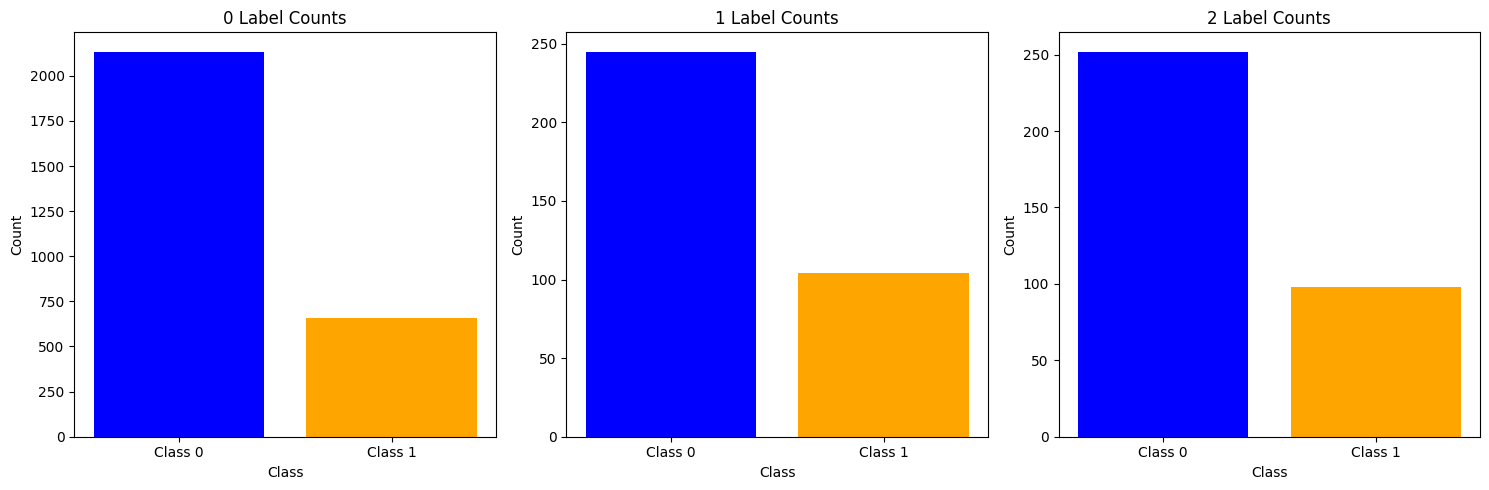

In [16]:
arrays = [y_train, y_val, y_test]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print('Showing the bar plots of Train Dataset, Validation Dataset and Test Dataset')
for i, arr in enumerate(arrays):
    class_counts = np.sum(arr, axis=0)
    axes[i].bar(np.arange(len(class_counts)), class_counts, color=['blue', 'orange'])
    axes[i].set_title(f'{i} Label Counts')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(np.arange(len(class_counts)))
    axes[i].set_xticklabels(['Class 0', 'Class 1'])
plt.tight_layout()
plt.show()